$$
u(x,y) = 5(-2x+3y)cos(3x+2y)+3y^2\\
0 \leq x \leq 1,\\
0 \leq y \leq 1\\
$$

$$
u_{xx} = 45 (2 x - 3 y) cos(3 x + 2 y) + 60 sin(3 x + 2 y)\\
u_{yy} = 6 + 20 (2 x - 3 y) cos(3 x + 2 y) - 60 sin(3 x + 2 y)\\
f(x,y) = u_{xx} + u_{yy} = 6 + 65 (2 x - 3 y) cos(3 x + 2 y)\\
$$


In [106]:
import numpy as np
from scipy.integrate import dblquad
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [107]:
def errors(true_values, test_values):
    mse = np.average((true_values - test_values)**2)
    mae = np.average(np.abs(true_values - test_values))
    mx = np.max(np.abs(true_values - test_values))
    print(f"MSE: {mse:.2e}, MAE: {mae:.2e}, MAX: {mx:.2e}")

In [108]:
xmin = ymin = 0
xmax = ymax = 1
h = 0.1
X = np.arange(xmin, xmax+h, h)
Y = np.arange(ymin, ymax+h, h)
n = len(X) - 1
solution_points = np.zeros(n**2)

In [109]:
sp.var('de dw dn ds x y b')
solution = 5*(-2*x+3*y)*sp.cos(3*x+2*y)+3*y**2
solution

3*y**2 + (-10*x + 15*y)*cos(3*x + 2*y)

In [110]:
eq = h*de - h*dw + h*dn - h*ds - b
phi_B = (sp.diff(solution, y).subs({y: ymin}))
phi_T = sp.diff(solution, y).subs({y: ymax})
phi_L = (sp.diff(solution, x).subs({x: xmin}))
phi_R = sp.diff(solution, x).subs({x: xmax})
psi_T = solution.subs({y: ymax})
psi_R = solution.subs({x: xmax})
f = sp.expand(solution.diff((x, 2)) + solution.diff((y, 2)))
f

130*x*cos(3*x + 2*y) - 195*y*cos(3*x + 2*y) + 6

In [111]:
# Boundary Condition
psi_R

3*y**2 + (15*y - 10)*cos(2*y + 3)

In [112]:
def get_pos(i, j): return n*(i-1)+j-1


solution_grid = np.zeros((n, n))
for i in range(1, n+1):
    for j in range(1, n+1):
        solution_grid[i-1][j-1] = solution_points[get_pos(i, j)] = solution.subs(
            [(x, X[j-1]+h/2), (y, Y[i-1]+h/2)]).evalf()

In [113]:
eq

-b + 0.1*de + 0.1*dn - 0.1*ds - 0.1*dw

In [114]:
mxy = np.zeros((n**2, 6))
f_lambdified = sp.lambdify((x, y), f, 'numpy')
sp.var('P E W N S')

for i in range(1, n+1):
    for j in range(1, n+1):
        eqi = eq
        if i == 1:  # cell is in the first row
            eqi = eqi.subs({ds: phi_B})
        if j == 1:  # cell is in the first column
            eqi = eqi.subs({dw: phi_L})
        if i == n:  # cell is in the last row
            # eqi = eqi.subs({dn: phi_T})
            eqi = eqi.subs({dn: (psi_T - P) / (h / 2)})
        if j == n:  # cell is in the last column
            # eqi = eqi.subs({de: phi_R})
            eqi = eqi.subs({de: (psi_R - P) / (h / 2)})

        if eqi.has(de):
            eqi = eqi.subs({de: (E - P) / h})
        if eqi.has(dw):
            eqi = eqi.subs({dw: (P - W) / h})
        if eqi.has(dn):
            eqi = eqi.subs({dn: (N - P) / h})
        if eqi.has(ds):
            eqi = eqi.subs({ds: (P - S) / h})

        eqi = sp.expand(eqi)
        b_val = dblquad(f_lambdified, X[j-1],
                        X[j-1]+h/2, Y[i-1], Y[i-1]+h/2)[0]
        eqi = eqi.subs([(b, b_val), (x, X[j-1]+h/2), (y, Y[i-1]+h/2)])
        print(eqi)
        col = sp.collect(eqi, [S, W, P, E, N], evaluate=False)
        last_key = list(col.keys())[-1]
        mxy[get_pos(i, j)] = [col.get(S, 0), col.get(W, 0), col.get(
            P, 0), col.get(E, 0), col.get(N, 0), col.get(last_key, 0)]

mxy.shape

1.0*E + 1.0*N - 2.0*P - 0.491608393364463
1.0*E + 1.0*N - 3.0*P + 1.0*W - 1.44618023399401
1.0*E + 1.0*N - 3.0*P + 1.0*W - 1.36558714745098
1.0*E + 1.0*N - 3.0*P + 1.0*W - 1.25619625858408
1.0*E + 1.0*N - 3.0*P + 1.0*W - 1.1020204685796
1.0*E + 1.0*N - 3.0*P + 1.0*W - 0.88616384787245
1.0*E + 1.0*N - 3.0*P + 1.0*W - 0.595311814622033
1.0*E + 1.0*N - 3.0*P + 1.0*W - 0.2240621983343
1.0*E + 1.0*N - 3.0*P + 1.0*W + 0.221574595640604
1.0*N - 4.0*P + 1.0*W + 19.2210941524053
1.0*E + 1.0*N - 3.0*P + 1.0*S + 1.11394004709138
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W + 0.0014504179778002
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W + 0.0317994445020607
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W + 0.0460736010673506
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W + 0.0413793179630081
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W + 0.0162383808800753
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W - 0.0292867446786944
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W - 0.0935579358713813
1.0*E + 1.0*N - 4.0*P + 1.0*S + 1.0*W - 0.173419670039782
1.0*N

(100, 6)

In [115]:
A = np.zeros((n**2, n**2))
B = np.zeros(n**2)
for i in range(n**2):
    B[i] = -mxy[i][5]
    A[i, i] = mxy[i][2]
    if mxy[i][0] != 0:
        A[i, i-n] = mxy[i][0]
    if mxy[i][1] != 0:
        A[i, i-1] = mxy[i][1]
    if mxy[i][3] != 0:
        A[i, i+1] = mxy[i][3]
    if mxy[i][4] != 0:
        A[i, i+n] = mxy[i][4]
A

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -3.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -3., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -5.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -5.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -6.]])

In [116]:
np.savetxt('matrix_A2.txt', A, fmt='%.1f')
np.savetxt('matrix_B2.txt', B, fmt='%.2f')

In [117]:
numerical_solution_points = np.linalg.solve(A, B)
numerical_solution_grid = numerical_solution_points.reshape(-1, n)

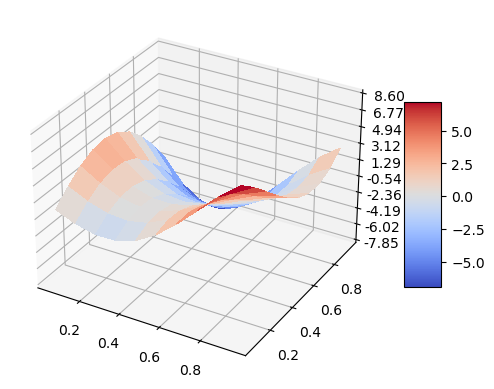

In [118]:
XX, YY = np.meshgrid(X[0:-1] + h/2, Y[0:-1] + h/2)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, solution_grid, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

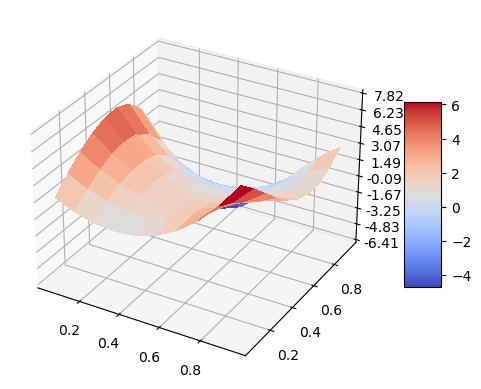

In [119]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, numerical_solution_grid, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

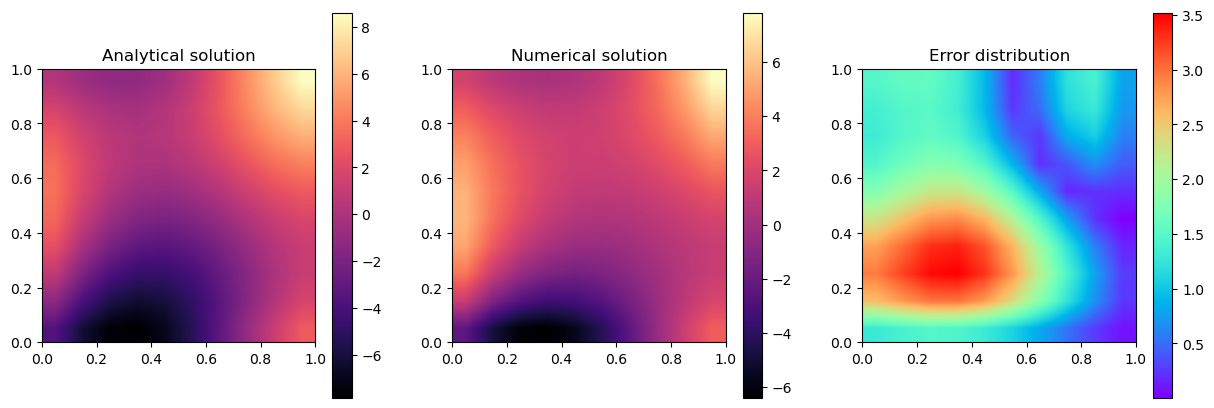

MSE: 3.14e+00, MAE: 1.49e+00, MAX: 3.52e+00


In [120]:
analytical_solution = solution_grid
numerical_solution = numerical_solution_grid

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph in the first subplot
# axes[0].imshow(analytical_solution, extent=[xmin, xmax, ymin, ymax], cmap='magma', interpolation='bilinear')
axes[0].set_title("Analytical solution")

# Plot the second graph in the second subplot
# axes[1].imshow(numerical_solution, extent=[xmin, xmax, ymin, ymax], cmap='magma', interpolation='bilinear')
axes[1].set_title("Numerical solution")
axes[2].set_title("Error distribution")
cbar0 = fig.colorbar(axes[0].imshow(analytical_solution, extent=[
                     xmin, xmax, ymin, ymax], cmap='magma', interpolation='bilinear'), ax=axes[0])
cbar1 = fig.colorbar(axes[1].imshow(numerical_solution, extent=[
                     xmin, xmax, ymin, ymax], cmap='magma', interpolation='bilinear'), ax=axes[1])
cbar1 = fig.colorbar(axes[2].imshow(np.abs(numerical_solution-analytical_solution), extent=[
                     xmin, xmax, ymin, ymax], cmap='rainbow', interpolation='bilinear'), ax=axes[2])
plt.show()

errors(solution_points, numerical_solution_points)